# Les moindres carrés via une décomposition QR ☕️
## I. Introduction

En *data science*, nous ne faisons pas seulement face à des modèles mathématiques que nous souhaitons programmer. Nous devons aussi tenir compte du fait que les nombres que nous manipulons ont une représentation sur la machine qui les stocke. De manière paradigmatique, considérons la fonction suivante&nbsp;:

$$f(x)=\text{ln}\big(\text{exp}(x)\big)=x.$$

Les deux formulations sont parfaitement indentiques. Observons cela via $\texttt{numpy}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


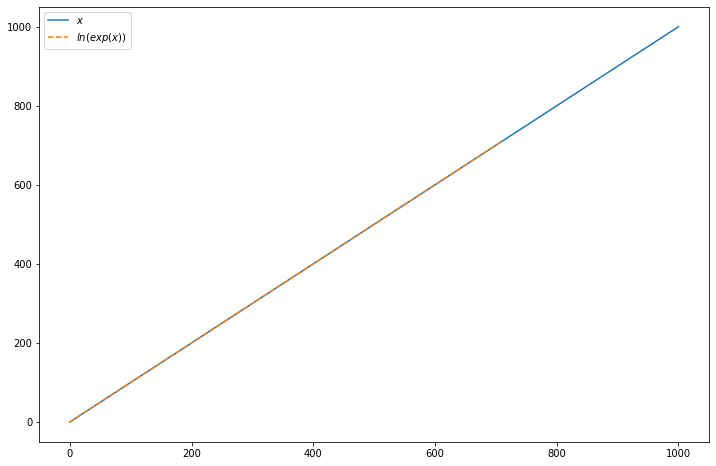

In [2]:
x = np.linspace(0, 1000, 500)
y_1 = np.log(np.exp(x))
y_2 = x

plt.figure(figsize=(12, 8))

plt.plot(x, y_2, label=r'$x$')
plt.plot(x, y_1, '--', label=r'$ln(exp(x))$')

plt.legend()
plt.show()

Nous rencontrons une erreur ! Cela vient évidemment du fait que le calcul de l'exponentielle lorsque $x$ devient trop grand induit un $\texttt{overflow}$ que le logarithme ne peut plus interpréter. En observant $\text{ln}\big(\text{exp}(x)\big)=x$, nous avons en quelque sorte utilisé une astuce (clairement triviale ici) mathématique nous permettant d'obtenir notre résultat malgré tout. De manière similaire, nous utilisons souvent en *machine learning* la fonction *softmax*:

$$\text{softmax}(x)_j=\frac{e^{x_j}}{\sum_i e^{x_i}},$$

notamment comme fonction de lien en *deep learning* ou en *régression logistique* afin de transformer notre vecteur de *logit* en vecteur de probabilités. Implémentons cette fonction.

In [3]:
import numpy as np

def softmax(x):
    return np.exp(x)/np.exp(x).sum()

x = [10, 12]
print('Softmax [10, 12]:', softmax(x))

x = [-10, 12]
print('Softmax [-10, 12]:', softmax(x))

x = [748, 750]
print('Softmax [748, 750]:', softmax(x))


Softmax [10, 12]: [0.11920292 0.88079708]
Softmax [-10, 12]: [2.78946809e-10 1.00000000e+00]
Softmax [748, 750]: [nan nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Le calcul de l'exponentielle de $750$ entraîne à nouveau un $\texttt{overflow}$ et nous empêche de calculer le *softmax*. La stratégie consiste à réduire la taille du plus grand nombre que notre exponentielle devra calculer de la manière suivante&nbsp;:

$$\text{softmax}(x)_j=\frac{e^{x_j}}{\sum_i e^{x_i}}=\frac{e^{x_j}}{\sum_i e^{x_i}}\frac{e^{-\text{max}(x)}}{e^{-\text{max}(x)}}=\frac{e^{x_j-\text{max}(x)}}{\sum_i e^{x_i-\text{max}(x)}}.$$

Réimplémentons notre *softmax*.

In [4]:
import numpy as np

def softmax(x):
    return np.exp(x-np.max(x))/np.exp(x-np.max(x)).sum()

x = [10, 12]
print('Softmax [10, 12]:', softmax(x))

x = [-10, 12]
print('Softmax [-10, 12]:', softmax(x))

x = [748, 750]
print('Softmax [748, 750]:', softmax(x))



Softmax [10, 12]: [0.11920292 0.88079708]
Softmax [-10, 12]: [2.78946809e-10 1.00000000e+00]
Softmax [748, 750]: [0.11920292 0.88079708]


De très nombreuses astuces de ce type existent et sont implémentées dans les différents *frameworks*.

C'est exactement cela que nous voulons faire avec les moindres carrés via une décomposition QR. Calculer notre estimateur des moindres carrés est beaucoup plus stable après une décomposition QR que dans sa formulation telle que nous l'avons vue.



---



## II. Décomposition QR
Soit une matrice $A\in\mathbb{R}^{m\times n}$. La décomposition $QR$ de la matrice $A$ est&nbsp;:

$$A=QR,$$

où $Q$ est une matrice orthogonale (par colonne si rectangulaire) et $R$ une matrice diagonale supérieure. On retrouve d'ailleurs parfois l'appellation "décomposition $QU$" où $U$ signifie *Upper triangular*. Une matrice orthogonale par colonne implique $Q^TQ=I$ et donc $m\geq n$. En effet, si une famille de vecteurs est plus grande que la dimension de l'espace, alors elle est forcément liée.

### A. Procédé de Gram-Schmidt
Il existe plusieurs stratégies permettant de réaliser cette décomposition et nous utiliserons celle basée sur le procédé (ou algorithme) de Gram-Schmidt. Soit $F=\{u_1, ..., u_n\}$ une famille de vecteurs libres. Le procédé de Gram-Schmidt a pour objectif de construire une base orthonormale $B=\{e_1, ..., e_n\}$ à partir de $F$.

L'opération de base du procédé de Gram-Schmidt est l'opérateur de projection&nbsp;:

$$\textrm{proj}_u(v)=\Pi_u(v)=\frac{\langle v, u\rangle }{\langle u, u\rangle}u,$$

où le vecteur $v$ est projeté orthogonalement sur $u$.

Le procédé itère sur l'ensemble des vecteurs de la famille $F$ de la manière suivante.


1.  $v_1=u_1$ et $e_1=v_1/\lVert v_1\rVert_2$,
2.  $v_2=u_2-\Pi_{e_1}(u_2)$ et $e_2=v_2/\lVert v_2\rVert_2$,
3.  ...
4.  $v_n=u_n-\sum_{i=1}^{n-1}\Pi_{e_i}(u_n)$ et $e_n=v_n/\lVert v_n\rVert_2$.


La famille $\{e_1, ..., e_n\}$ ainsi construite est une base orthonormée et engendre le même sous-espace vectoriel que la famille $F$.

**<span style='color:blue'> Exercice
</span>** 
**Complétez le code ci-dessous afin d'implémenter le procédé de Gram-Schmidt.**

----

In [8]:
import numpy as np

def projector(u, v):
    ####### Complete this part ######## or die ####################
    sc_1 = np.dot(u, v)
    sc_2 = np.dot(u, u)
    return sc_1/sc_2*u
    ###############################################################

def gram_schmidt(matrix):
    ####### Complete this part ######## or die ####################

    orthogonal = []
    for i in range(matrix.shape[1]):
        v = matrix[:, i]
        for j in range(i):
            v = v - projector(orthogonal[j], v)
        orthogonal.append(v/np.linalg.norm(v))
    return np.stack(orthogonal, axis=1)
    ###############################################################

A = np.random.random((4, 4))

Q = gram_schmidt(A)

print('Une matrice identite :\n', np.dot(Q.T, Q))



Une matrice identite :
 [[ 1.00000000e+00 -4.00784158e-17 -8.49217260e-17  1.64720020e-16]
 [-4.00784158e-17  1.00000000e+00 -3.90232246e-18  6.97837414e-17]
 [-8.49217260e-17 -3.90232246e-18  1.00000000e+00 -4.39278378e-18]
 [ 1.64720020e-16  6.97837414e-17 -4.39278378e-18  1.00000000e+00]]


### B. Décomposition QR

Soit $A\in\mathbb{R}^{m\times n}$ telle que les vecteurs colonnes sont libres. Notons $\{a_1, ..., a_n\}$ l'ensemble des vecteurs colonnes. Soit $\{e_1, ..., e_n\}$ une base orthonormale résultant du procédé de Gram-Schmidt appliqué aux vecteurs colonnes de $A$.

De manière assez directe, on observe que&nbsp;:

$$a_1=\langle a_1, e_1\rangle e_1.$$ 

Dit autrement, $a_1$ est un vecteur co-linéaire à $e_1$ dont la norme est $\langle e_1, a_1\rangle$ (sachant que $e_1$ est unitaire). Le vecteur $a_2$ est un peu plus complexe à reconstruire&nbsp;: 

$$a_2=\langle a_2, e_2\rangle e_2+\langle a_2, e_1\rangle e_1.$$ 

Autrement dit, $a_2$ est une combinaison linéaire de $e_1$ et $e_2$, ce qui est logique puisque $e_2$ est construit en retirant la composante non orthogonale à $e_1$ de $a_2$.
On réitère l'opération jusqu'à $a_n=\sum_i \langle e_i, a_n\rangle e_i$.

En notant&nbsp;:

$$\begin{aligned}
    Q=[e_1, ..., e_n]\textrm{ et }R=\begin{bmatrix}
        \langle e_1, a_1\rangle & \langle e_1, a_2\rangle & \langle e_1, a_3\rangle & \ldots&\langle e_1, a_n\rangle\\
        0 & \langle e_2, a_2\rangle & \langle e_2, a_3\rangle& \ldots&\langle e_2, a_n\rangle\\
        0 &0 & \langle e_3, a_3\rangle& \ldots&\langle e_3, a_n\rangle\\
        0 & 0 & 0 & \ddots & \vdots\\
        0 & 0 & 0 & \ldots & \langle e_n, a_n\rangle
        \end{bmatrix}
    \end{aligned}$$
    
on retrouve bien $A=QR$.

### C. Exemple

Soit la matrice suivante&nbsp;:

$$\begin{aligned}
    A=\begin{bmatrix}
    1&-1\\
    2&0\\
    2&2
    \end{bmatrix}=[a_1, a_2]
\end{aligned}$$

Commençons la procédure de Gram-Schmidt. On note&nbsp;:

$$v_1=a_1\textrm{ et }e_1=v_1/\lVert v_1\rVert_2=\Big[\frac{1}{3},\frac{2}{3}, \frac{2}{3}\Big]^T$$

Et&nbsp;:

$$v_2=a_2-\Pi_{e_1}(a_2)\textrm{ et }e_2=v_2/\lVert v_2\rVert_2=\Big[-\frac{2}{3},-\frac{1}{3}, \frac{2}{3}\Big]^T$$

On vérifie assez bien que $e_1$ et $e_2$ sont orthogonaux et unitaires.
Calculons maintenant les produits scalaires&nbsp;:

$$\langle e_1, a_1\rangle=3,\ \langle e_1, a_2\rangle=1\textrm{ et }\langle e_2, a_2\rangle=2$$

Nous avons donc

$$\begin{aligned}
    Q=\begin{bmatrix}
    1/3&-2/3\\
    2/3&-1/3\\
    2/3&2/3
    \end{bmatrix}\text{ et }R=\begin{bmatrix}
    3&1\\
    0&2
    \end{bmatrix}
    \end{aligned}$$
    
On vérifie facilement qu'on a bien l'égalité $A=QR$.


**<span style='color:blue'> Exercice
</span>** 
**Complétez le code ci-dessous en ré-utilisant votre implémentation du procédé de Gram-Schmidt afin d'obtenir une décomposition QR.**

----

In [9]:
def qr(matrix):
    ####### Complete this part ######## or die ####################
    Q = gram_schmidt(matrix)
    R = np.zeros((Q.shape[1], Q.shape[1]))
    for i in range(matrix.shape[1]):
        for j in range(i+1):
            R[j, i] = np.dot(Q[:, j], matrix[:, i])
    return Q, R
    ###############################################################

A = np.array([[1, -1], [2, 0], [2, 2]])

Q, R = qr(A)
print('Notre matrice initiale :\n', A)
print('Notre matrice initiale reconstruite :\n', np.dot(Q, R))


Notre matrice initiale :
 [[ 1 -1]
 [ 2  0]
 [ 2  2]]
Notre matrice initiale reconstruite :
 [[ 1.00000000e+00 -1.00000000e+00]
 [ 2.00000000e+00 -1.11022302e-16]
 [ 2.00000000e+00  2.00000000e+00]]


## III. Application aux moindres carrés
### A. Notre estimation via une décomposition QR

Soit $X\in\mathbb{R}^{n\times d}$, $y\in\mathbb{R}^n$ et $\beta\in\mathbb{R}^d$. Notre objectif est de résoudre le problème d'optimisation suivant&nbsp;

$$\hat{\beta}=\text{argmin}_{\beta\in\mathbb{R}^d}\lVert X\beta-y\rVert_2^2.$$

Nous avons déjà vu que si $X^TX$ est inversible, alors nous avons la solution analytique suivante&nbsp;:

$$\hat{\beta}=(X^TX)^{-1}X^Ty.$$

Considérons maintenant la décomposition $QR$ de la matrice $X$ (i.e. $X=QR$). Nous avons ainsi&nbsp;:

$$\begin{aligned}
    \hat{\beta}&=(X^TX)^{-1}X^Ty\\
    &=((QR)^TQR)^{-1}(QR)^Ty\\
    &= ((R^TQ^TQR)^{-1}R^TQ^Ty\\
    &=(R^TR)^{-1}R^TQ^Ty\\
    &=R^{-1}(R^T)^{-1}R^TQ^Ty\\
    &=R^{-1}Q^Ty.
\end{aligned}$$

Rappellons que si $A$ et $B$ sont deux matrices inversibles, nous avons $(AB)^{-1}=B^{-1}A^{-1}$.

### B. Exercice

Soit la matrice suivante&nbsp;:

$$\begin{aligned}
    X=\begin{bmatrix}
    1&-1\\
    0&10^{-5}\\
    0&0
    \end{bmatrix}\textrm{ et }Y=\begin{bmatrix}
    0\\
    10^{-5}\\
    0
    \end{bmatrix}
    \end{aligned}$$
    

**<span style='color:blue'> Exercice 1
</span>** 
**Supposons que l'algorithme tourne sur une machine où les nombres sont arrondis après 8 décimales (i.e. si $|x|<10^{-8}$ alors $x:=0$). Calculez l'estimateur des moindres carrés SANS passer par une décomposition QR.**

----
**<span style='color:blue'> Exercice 2
</span>** 
**Supposons que l'algorithme tourne sur une machine où les nombres sont arrondis après 8 décimales (i.e. si $|x|<10^{-8}$ alors $x:=0$). Calculez l'estimateur des moindres carrés AVEC une décomposition QR.**

----

**<span style='color:blue'> Exercice 3
</span>** 
**Implémentez les deux stratégies précédentes en utilisant $\texttt{numpy}$. Que constatez-vous ?**

----

In [21]:
import numpy as np

X = np.array([[1, -1], [0, 1e-5], [0, 0]])
y = np.array([[0], [1e-5], [0]])

####### Complete this part ######## or die ####################
XXt_inv= X.T.dot(X))
beta_est = XXt_inv.dot(X.T).dot(y)

###############################################################

print("Notre estimateur avec la méthode classique :\n", beta_est)
# print("Notre estimateur avec la méthode QR :\n", beta_qr_est)


[[ 1. -1.]
 [-1.  1.]]
Notre estimateur avec la méthode classique :
 [[0.99999979]
 [0.99999979]]


Cette exemple simple montre déjà les avantages de la décomposition QR dans le cadre des moindres carrés. On imagine sans mal son intérêt dans des exemples beaucoup plus compliqués où les dépendances linéaires sont peut-être plus difficiles à discerner au milieu des perturbations et du bruit.